## CNN-Project-Exercise
We'll be using the CIFAR-10 dataset, which is very famous dataset for image recognition! 

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 


** Download the data for CIFAR from here: https://www.cs.toronto.edu/~kriz/cifar.html **

In [2]:
CIFAR_DIR = 'cifar-10-batches-py/'

The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle. 

** Load the Data. Use the Code Below to load the data: **

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [4]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [5]:
all_data = [0,1,2,3,4,5,6]

In [6]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [7]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

Loaded in this way, each of the batch files contains a dictionary with the following elements:
* data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
* labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

* label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [9]:
X = data_batch1[b"data"] 
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

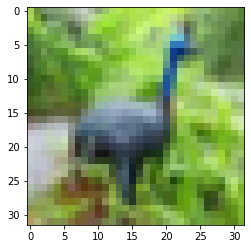

In [10]:
plt.imshow(X[6])

# Helper Functions for Dealing With Data.

In [11]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [12]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [13]:
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Creating the Model

In [14]:
import tensorflow.compat.v1 as tf

In [15]:
tf.disable_eager_execution()
tf.disable_eager_execution()

In [16]:
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3] )
y_true = tf.placeholder(tf.float32, shape=[None, 10])

In [17]:
hold_prob = tf.placeholder(tf.float32)
hold_prob_1 = tf.placeholder(tf.float32)
hold_prob_2 = tf.placeholder(tf.float32)
hold_prob_3 = tf.placeholder(tf.float32)

In [18]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

In [19]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [20]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [21]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [22]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

In [23]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [24]:
convo_1 = convolutional_layer(x,shape=[3,3,3,32])
convo_1_pooling = max_pool_2by2(convo_1)
dropout_layer_1 = tf.nn.dropout(convo_1_pooling, hold_prob_1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
convo_2 = convolutional_layer(dropout_layer_1, shape=[3,3,32,64])
convo_2_pooling = max_pool_2by2(convo_2)
dropout_layer_2 = tf.nn.dropout(convo_2_pooling, hold_prob_2)

In [26]:
convo_3 = convolutional_layer(dropout_layer_2, shape=[3,3,64,128])
convo_3_pooling = max_pool_2by2(convo_3)
dropout_layer_3 = tf.nn.dropout(convo_3_pooling, hold_prob_3)

In [27]:
flat_layer = tf.reshape(dropout_layer_3, shape=[-1, 4*4*128])

In [28]:
full_layer = normal_full_layer(flat_layer, 512)

In [29]:
dropout_layer = tf.nn.dropout(full_layer, hold_prob)

In [30]:
y_pred = normal_full_layer(dropout_layer, 10)

In [31]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [32]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

In [33]:
init = tf.global_variables_initializer()

In [36]:
steps = 200000

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(steps):
        
        batch_x , batch_y = ch.next_batch(100)
        
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5, hold_prob_1:0.8,hold_prob_2:0.7,hold_prob_3:0.6})
        
        # PRINT OUT A MESSAGE EVERY 10000 STEPS
        if i%10000 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x: ch.test_images,y_true: ch.test_labels,hold_prob:1.0, hold_prob_1:0.8,hold_prob_2:0.7,hold_prob_3:0.6}))
            print('\n')

Currently on step 0
Accuracy is:
0.1024


Currently on step 10000
Accuracy is:
0.5532


Currently on step 20000
Accuracy is:
0.6437


Currently on step 30000
Accuracy is:
0.6817


Currently on step 40000
Accuracy is:
0.7043


Currently on step 50000
Accuracy is:
0.7137


Currently on step 60000
Accuracy is:
0.726


Currently on step 70000
Accuracy is:
0.7321


Currently on step 80000
Accuracy is:
0.7398


Currently on step 90000
Accuracy is:
0.7453


Currently on step 100000
Accuracy is:
0.7481


Currently on step 110000
Accuracy is:
0.7496


Currently on step 120000
Accuracy is:
0.7524


Currently on step 130000
Accuracy is:
0.7541


Currently on step 140000
Accuracy is:
0.7468


Currently on step 150000
Accuracy is:
0.7573


Currently on step 160000
Accuracy is:
0.7521


Currently on step 170000
Accuracy is:
0.7537


Currently on step 180000
Accuracy is:
0.7577


Currently on step 190000
Accuracy is:
0.7589


